<a href="https://colab.research.google.com/github/ssubbinn/ESAA/blob/main/11%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###결정 트리 실습-사용자 행동 인식 데이터 세트



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
feature_name_df = pd.read_csv('/content/drive/MyDrive/김수빈/esaa/data/UCI HAR Dataset/UCI HAR Dataset/features.txt',sep='\s+', header=None,names=['column_index','column_name'])

#피처명 index를 제거사고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


- 피처명을 보면 인체의 움직임과 관련된 속성의 평균/표준편차가 X,Y,Z축 값으로 돼 있음을 유추 가능
- 주의사항: features_info.txt 파일은 중복된 피처명을 가지고 있기에 변경 필요

In [3]:
#중복된 피처명이 얼마나 있는지 알아보기
feature_dup_df=feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()
#42개 피처명 중복

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [4]:
#원본 피처명에 _1또는 _2를 추가하여 새로운 피처명을 반환해주는 함수 생성
def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df=pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),columns=['dup_cnt'])
  feature_dup_df=feature_dup_df.reset_index()
  new_feature_name_df=pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
  new_feature_name_df['column_name']=new_feature_name_df[['column_name','dup_cnt']].apply(lambda x:x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis=1)
  new_feature_name_df=new_feature_name_df.drop(['index'], axis=1)
  return new_feature_name_df

In [5]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('/content/drive/MyDrive/김수빈/esaa/data/UCI HAR Dataset/UCI HAR Dataset/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    #중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('/content/drive/MyDrive/김수빈/esaa/data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt',sep='\s+', names=feature_name)
    X_test = pd.read_csv('/content/drive/MyDrive/김수빈/esaa/data/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('/content/drive/MyDrive/김수빈/esaa/data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('/content/drive/MyDrive/김수빈/esaa/data/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [6]:
print('## 학습 피처 데이터셋 info()')
print(X_train.info())

## 학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [7]:
print(y_train['action'].value_counts())
#레이블 값은 1,2,3,4,5,6 이고 비교적 고르게 분포돼 있다

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [8]:
#DecisionTreeClassifier를 이용해 동작 예측 분류 수행
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#예제 반복 시마다 동일한 예측 결과 도출을 위해 random_state 설정
dt_clf=DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred=dt_clf.predict(X_test)
accuracy=accuracy_score(y_test, pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

#DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [11]:
#결정 트리의 트리 깊이가 예측 정확도에 주는 영향 살펴보기
#GridSearchCV에서 max_depth 늘리며 예측 성능 측정
from sklearn.model_selection import GridSearchCV

params={'max_depth' : [6,8,10,12,16,20,24]}

grid_cv=GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치: 0.8513
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 16}


In [12]:
#GridSearchCV 객체의 cv_results_ 속성을 DataFrame으로 생성.
cv_results_df=pd.DataFrame(grid_cv.cv_results_)

#max_depth 파라미터 값과 그때의 테스트 세트, 학습 데이터 세트의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score']]

#max_depth 16일때 정확도 0.8513으로 정점

,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844135
4,16,0.851344
5,20,0.850800
6,24,0.849440


In [13]:
max_depths = [6,8,10,12,16,20,24]
#max_depth 값을 변화시키면서 그때마다 학습과 테스트 세트에서의 예측 성능 측정
for depth in max_depths:
  dt_clf=DecisionTreeClassifier(max_depth=depth, random_state=156)
  dt_clf.fit(X_train, y_train)
  pred = dt_clf.predict(X_test)
  accuracy = accuracy_score(y_test,pred)
  print('max_depth ={0} 정확도 : {1:.4f}'.format(depth, accuracy))

#max_depth=8일때 87.07%로 가장 높은 정확도 그 이후 계속 정확도 감소

max_depth =6 정확도 : 0.8558
max_depth =8 정확도 : 0.8707
max_depth =10 정확도 : 0.8673
max_depth =12 정확도 : 0.8646
max_depth =16 정확도 : 0.8575
max_depth =20 정확도 : 0.8548
max_depth =24 정확도 : 0.8548


In [14]:
params={'max_depth' : [8,12,16,20], 'min_samples_split':[16,24]}

grid_cv=GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


In [15]:
best_df_clf=grid_cv.best_estimator_
pred1=best_df_clf.predict(X_test)
accuracy=accuracy_score(y_test,pred1)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy))

결정 트리 예측 정확도:0.8717


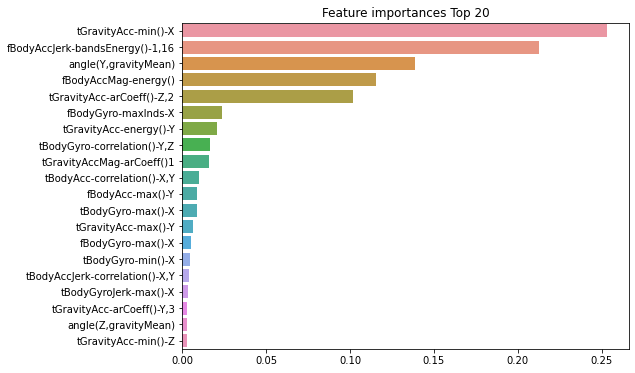

In [17]:
#중요도가 높은 피처 top20
import seaborn as sns

ftr_importances_values=best_df_clf.feature_importances_
#Top 중요도로 정렬을 쉽게 하고, seaborn의 막대그래프로 쉽게 표현하기 위해 series 변환
ftr_importances=pd.Series(ftr_importances_values, index=X_train.columns)
#중요도값 순으로 series를 정렬
ftr_top20=ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()